# NYC Airbnb listing price regression

In [1]:
# Utilities and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Needed for coding
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
%config IPCompleter.use_jedi = False

# Models and metrics
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

In [2]:
dev_file = "development.csv"
eval_file = "evaluation.csv"

In [3]:
df_dev = pd.read_csv(dev_file)
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,NaN,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


## Data exploration and Pre-processing

In [4]:
df_dev.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

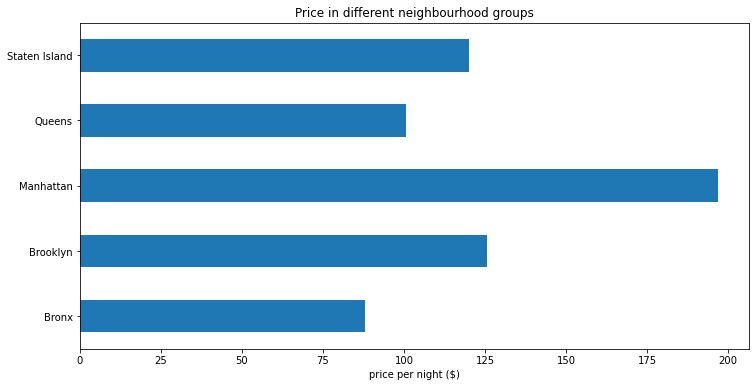

In [5]:
df_dev.groupby("neighbourhood_group")["price"].mean().plot(kind = 'barh')
plt.xlabel("price per night ($)")
plt.ylabel("")
plt.title("Price in different neighbourhood groups");

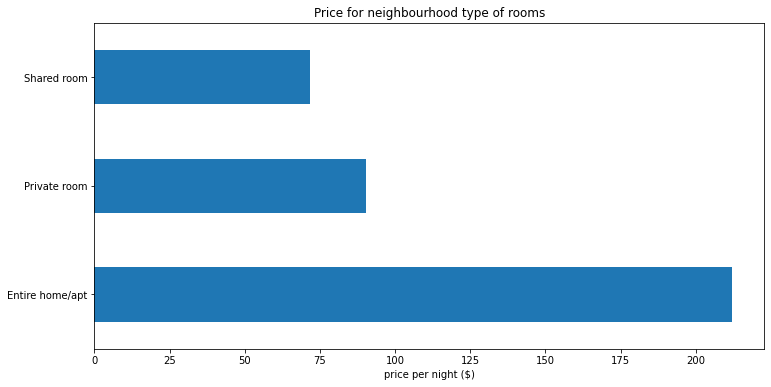

In [6]:
df_dev.groupby("room_type")["price"].mean().plot(kind = 'barh')
plt.xlabel("price per night ($)")
plt.ylabel("")
plt.title("Price for neighbourhood type of rooms");

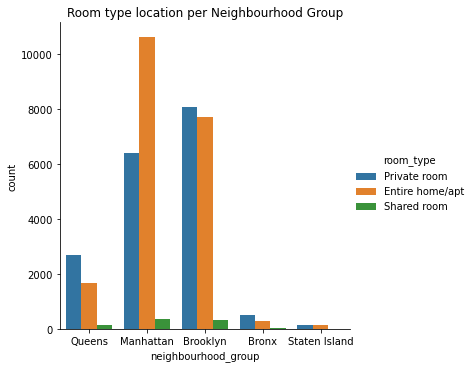

In [7]:
title = 'Room type location per Neighbourhood Group'
sb.catplot(x='neighbourhood_group', kind="count", hue="room_type", data=df_dev);
plt.title(title);

In [8]:
df_dev.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

#### Possible interesting features are:
- 'neighbourhood_group'
- 'room_type'
- 'minimum_nights',
- 'reviews_per_month'
- 'calculated_host_listings_count'
- 'Latitude'  
- 'Longitude'

## Target values

In [9]:
df_dev.price.describe()

count    39116.000000
mean       153.406995
std        242.218222
min          0.000000
25%         69.000000
50%        108.000000
75%        178.000000
max      10000.000000
Name: price, dtype: float64

In [10]:
mask = df_dev.price == 0
df_dev.drop(df_dev[mask].index).price.describe()

count    39106.000000
mean       153.446223
std        242.236765
min         10.000000
25%         69.000000
50%        108.000000
75%        178.000000
max      10000.000000
Name: price, dtype: float64

In [11]:
df_dev.drop(df_dev[mask].index, inplace=True)

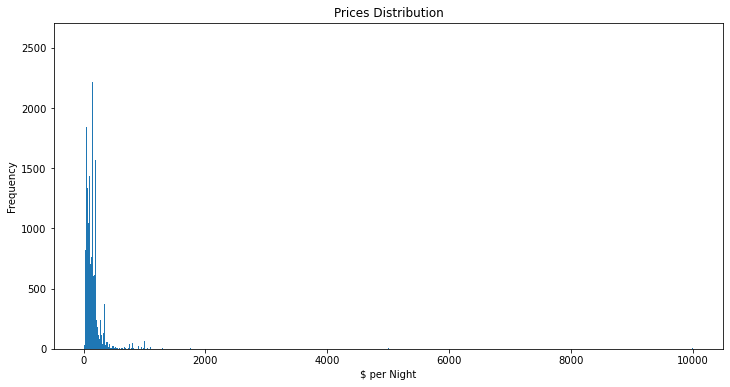

In [13]:
df_dev.price.plot(kind = 'hist', bins = 'fd');
plt.title("Prices Distribution")
plt.xlabel("$ per Night");

In [14]:
df_dev.price.describe()

count    39106.000000
mean       153.446223
std        242.236765
min         10.000000
25%         69.000000
50%        108.000000
75%        178.000000
max      10000.000000
Name: price, dtype: float64

### Handling missing values

In [15]:
df_dev.isna().sum()

id                                   0
name                                13
host_id                              0
host_name                           19
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       8040
reviews_per_month                 8040
calculated_host_listings_count       0
availability_365                     0
dtype: int64

We are not interested in host name and place name, so we will leave them out.  
__Instead number of reviews per month are interesting features__:

In [16]:
mask = df_dev.number_of_reviews == 0
df_dev.loc[mask, "reviews_per_month"] = 0

In [17]:
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,0.00,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


## Numerical Attributes

### Minimum nights stay

In [18]:
q = 99.95
stay_q = np.percentile(df_dev.minimum_nights, q)

In [19]:
mask = df_dev.minimum_nights > stay_q
df_dev.drop(df_dev[mask].index).minimum_nights.describe()

count    39097.000000
mean         6.886462
std         16.655844
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        365.000000
Name: minimum_nights, dtype: float64

In [20]:
df_dev.drop(df_dev[mask].index, inplace=True)

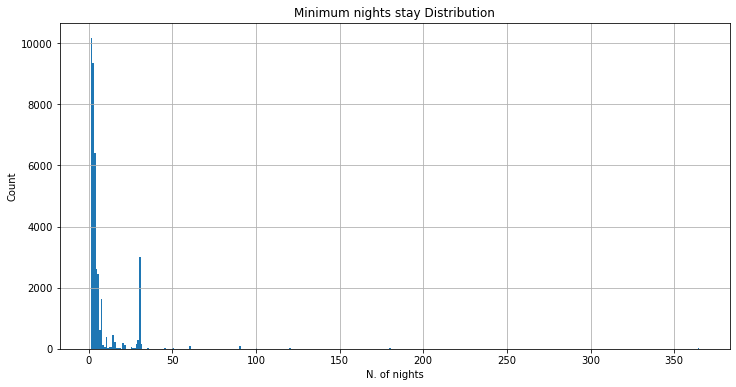

In [21]:
df_dev.minimum_nights.hist(bins = 365);
plt.title("Minimum nights stay Distribution")
plt.xlabel("N. of nights")
plt.ylabel("Count");

In [22]:
df_dev.minimum_nights.describe()

count    39097.000000
mean         6.886462
std         16.655844
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        365.000000
Name: minimum_nights, dtype: float64

In [178]:
df_dev.minimum_nights = pd.cut(df_dev.minimum_nights, bins = [0,1,3,5,30,500], labels= [1,3,5,30,100], duplicates= 'drop')

In [10]:
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,0.00,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


### Monthly reviews

In [180]:
df_dev.reviews_per_month.describe()

count    39097.000000
mean         1.093549
std          1.600048
min          0.000000
25%          0.040000
50%          0.370000
75%          1.590000
max         58.500000
Name: reviews_per_month, dtype: float64

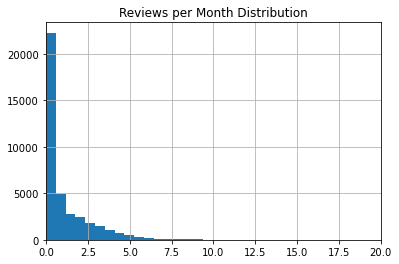

In [181]:
df_dev.reviews_per_month.hist(bins = 100)
plt.xlim((0,20))
plt.title("Reviews per Month Distribution");

__More than half do'nt have any monthly review__ !!  
I don't have much hope from this feature.

In [182]:
df_dev.reviews_per_month = pd.qcut(df_dev.reviews_per_month, q = [0,.75, .95, 1], labels= [1.6,5,10])

In [11]:
#df_dev = pd.get_dummies(df_dev, columns= ["reviews_per_month"],prefix="rpm", drop_first=True)
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,0.00,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


### Host Listings count

In [184]:
df_dev.calculated_host_listings_count.describe()

count    39097.000000
mean         7.206921
std         33.117574
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

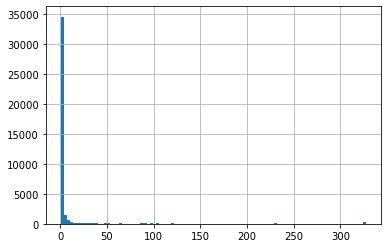

In [185]:
df_dev.calculated_host_listings_count.hist(bins = 100);

In [186]:
df_dev.calculated_host_listings_count = pd.cut(df_dev.calculated_host_listings_count, bins= [0,11,200,328], labels= [1,125,250])
df_dev.calculated_host_listings_count.value_counts()

1      36797
125     1847
250      453
Name: calculated_host_listings_count, dtype: int64

In [187]:
df_dev.availability_365.describe()

count    39097.000000
mean       112.916362
std        131.556827
min          0.000000
25%          0.000000
50%         46.000000
75%        226.000000
max        365.000000
Name: availability_365, dtype: float64

In [188]:
df_dev.availability_365 = pd.cut(df_dev.availability_365, bins = [-0.1,2,100,200,366], labels= [0,75,200,300] ,)
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,1.6,1,300
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,5.0,1,300
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,3,0,NaN,1.6,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,3,4,2019-07-07,5.0,1,75
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,1.6,1,200


## Catagorical Attributes and their encoding

### neighbourhood group

In [189]:
df_dev.neighbourhood_group.value_counts()

Manhattan        17355
Brooklyn         16063
Queens            4509
Bronx              873
Staten Island      297
Name: neighbourhood_group, dtype: int64

### Room type

In [190]:
df_dev.room_type.value_counts()

Entire home/apt    20409
Private room       17779
Shared room          909
Name: room_type, dtype: int64

In [23]:
df_dev = pd.get_dummies(df_dev, columns=["room_type"], drop_first= True)
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,75,1,2,2019-05-26,0.92,3,351,1,0
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,95,1,202,2019-05-27,3.31,2,263,1,0
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,130,2,0,NaN,0.00,1,0,0,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,150,2,4,2019-07-07,1.64,1,89,0,0
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,325,3,16,2019-04-20,0.42,1,103,0,0


In [192]:
df_dev_large = pd.get_dummies(df_dev, columns= ["neighbourhood"], drop_first=True)
df_dev_large.head(5)

,id,name,host_id,host_name,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,...,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside
0,12783632,NYC Mini Hotel,57230304,Imanuelly,40.74037,-73.88610,75,1,2,2019-05-26,...,0,0,0,0,0,0,0,0,0,0
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,40.76717,-73.95532,95,1,202,2019-05-27,...,0,0,0,0,0,0,0,0,0,0
2,17572926,Great 1 Bedroom on Upper East,36578169,James,40.77984,-73.94725,130,3,0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,40.70205,-73.91338,150,3,4,2019-07-07,...,0,0,0,0,0,0,0,0,0,0
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,40.68914,-73.97853,325,3,16,2019-04-20,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df_dev.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,75,1,2,2019-05-26,0.92,3,351,1,0
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,95,1,202,2019-05-27,3.31,2,263,1,0
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,130,2,0,NaN,0.00,1,0,0,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,150,2,4,2019-07-07,1.64,1,89,0,0
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,325,3,16,2019-04-20,0.42,1,103,0,0


## Model Building

### Feature selection

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [27]:
def select_features(X_train, y_train, X_test, k = 'all'):
    np.seterr(divide='ignore', invalid='ignore')
    
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k= k)
    
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    # transform train input data
    X_train_fs = fs.transform(X_train)
    
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [28]:
def make_train_test(df, test_size = 0.2, rs = None):
    X = df.iloc[:,1:].values
    y = df.iloc[:,0].values
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, shuffle = True, random_state = 99)
    return train_test_split(X, y, test_size= test_size, shuffle = True, random_state = rs)

In [29]:
def model_evalutation(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rep = f"""
    Model R2 score: {r2:.2f}
    Model MSE: {mse:.2f}
    """
    print(rep)
    
    # Create a Dataframe to compare values
    df = pd.DataFrame(data = {"True": y_test, "Predicted":y_pred})
    
    return df

In [30]:
df_dev.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

In [48]:
exclude = ['name', 'host_name', 'last_review','number_of_reviews','neighbourhood_group','neighbourhood']
df = df_dev.drop(exclude, axis=1)
if "neighbourhood" in df.columns:
    df = df.drop(["neighbourhood"], axis = 1)
    
# arrange price to be first column
cols = list(df.columns)
cols[2], cols[0] = cols[0], cols[2]
df = df.loc[df.price < np.percentile(df.price, 99.999999),cols]
df.head()

,latitude,host_id,id,longitude,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room
0,40.74037,57230304,12783632,-73.88610,75,1,0.92,3,351,1,0
1,40.76717,10698270,3463385,-73.95532,95,1,3.31,2,263,1,0
2,40.77984,36578169,17572926,-73.94725,130,2,0.00,1,0,0,0
3,40.70205,50981314,33913644,-73.91338,150,2,1.64,1,89,0,0
4,40.68914,48775347,9405895,-73.97853,325,3,0.42,1,103,0,0


In [49]:
X_train, X_test, y_train, y_test = make_train_test(df, rs=909)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, k = 'all')


Feature 2: 229.494774
Feature 3: 33.940097
Feature 4: 33.697857
Feature 0: 13.542137
Feature 6: 10.952678
Feature 5: 10.843639
Feature 7: 4.161461
Feature 8: 1.417093
Feature 9: 0.853107
Feature 1: 0.004820


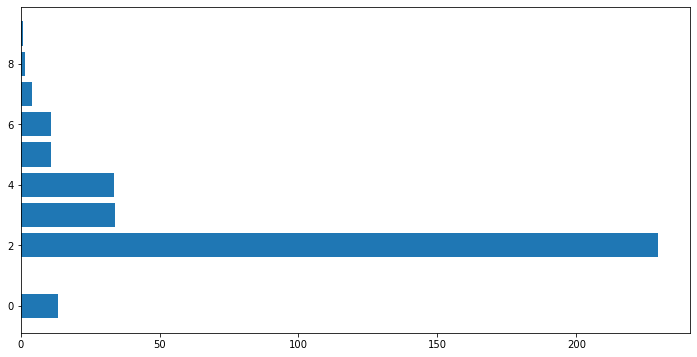

In [51]:
# what are scores for the features
for i in np.argsort(fs.scores_)[::-1]:
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.barh(np.arange(fs.scores_.size), fs.scores_)
plt.show()

### Simple LinearRegression

In [52]:
reg = LinearRegression()
reg.fit(X_train_fs, y_train)
y_hat = reg.predict(X_test_fs)

model_evalutation(y_test, y_hat)


    Model R2 score: 0.01
    Model MSE: 0.00
    


,True,Predicted
0,40.70787,40.734722
1,40.68886,40.729197
2,40.78587,40.726762
3,40.82639,40.735265
4,40.77914,40.730314
...,...,...
7814,40.67860,40.720771
7815,40.66734,40.727630
7816,40.76375,40.727858
7817,40.70388,40.736139


### RandomForest Regressor

In [53]:
def make_model(reg, params, X_train, y_train,scoring, cv = 5):
    grid_search = GridSearchCV(reg,cv = cv, param_grid=params, scoring = scoring)
    grid_search.fit(X_train, y_train)
    print("Best combination of Parameters:")
    print(grid_search.best_params_)
    print(f"Best {scoring} Score:{grid_search.best_score_}")
    return grid_search.best_estimator_

In [54]:
reg = RandomForestRegressor(n_jobs=-1)
RF_params = {
    "n_estimators": [50,70,100],
    "max_depth": [10, 15, None],
   "max_features": ["auto", "sqrt"],
    "min_impurity_decrease": [0.0, 0.01]
}
best_RF_reg = make_model(reg, RF_params, X_train_fs, y_train, scoring="r2", cv = 2)

Best combination of Parameters:
{'max_depth': None, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'n_estimators': 100}
Best r2 Score:0.2105386413509242


In [55]:
best_RF_reg.feature_importances_

array([0.14703853, 0.13462346, 0.27555068, 0.12848933, 0.05981412,
       0.10568187, 0.03936174, 0.09074741, 0.01389175, 0.00480111])

In [56]:
feature_names =df.columns[1:]

In [57]:
feature_names =df.columns[1:]
sorted(zip(feature_names, best_RF_reg.feature_importances_), key=lambda x: x[1],reverse=True)

[('longitude', 0.2755506848871606),
 ('host_id', 0.14703852798234185),
 ('id', 0.1346234608219284),
 ('price', 0.12848932663921608),
 ('reviews_per_month', 0.1056818652309559),
 ('availability_365', 0.09074741205657494),
 ('minimum_nights', 0.05981412056823622),
 ('calculated_host_listings_count', 0.03936174141393677),
 ('room_type_Private room', 0.01389175445613006),
 ('room_type_Shared room', 0.00480110594351911)]

In [58]:
y_hat = best_RF_reg.predict(X_test_fs)
model_evalutation(y_test, y_hat)


    Model R2 score: 0.24
    Model MSE: 0.00
    


,True,Predicted
0,40.70787,40.727442
1,40.68886,40.728899
2,40.78587,40.724871
3,40.82639,40.751741
4,40.77914,40.742363
...,...,...
7814,40.67860,40.705139
7815,40.66734,40.752516
7816,40.76375,40.733903
7817,40.70388,40.719590


In [59]:
del df

In [ ]:
df_dev.head()

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [100]:
mask = df_dev.name.isna()
text = df_dev.name.fillna("")

In [101]:
text.isna().sum()

0

In [102]:
m = TfidfVectorizer(stop_words='english', use_idf= False, norm= False)
res = m.fit_transform(text)
res

<39097x6889 sparse matrix of type '<class 'numpy.float64'>'
	with 186753 stored elements in Compressed Sparse Row format>

In [103]:
res.get_shape()

(39097, 6889)

In [104]:
all_words_scores = res.sum(axis = 0).tolist()[0]

In [105]:
all_words = m.get_feature_names()
all_words

['00',
 '000',
 '000sf',
 '000sqft',
 '001',
 '001ll',
 '002',
 '003',
 '004',
 '005',
 '01',
 '01401',
 '02',
 '03',
 '04',
 '05',
 '0min',
 '10',
 '100',
 '1000',
 '1000sq',
 '1000sqf',
 '10017',
 '100mbps',
 '100th',
 '101',
 '102',
 '10222',
 '10223',
 '10226',
 '10248',
 '10256',
 '10257',
 '10262',
 '10264',
 '10268',
 '10273',
 '10292',
 '10294',
 '10296',
 '103',
 '10303',
 '10304',
 '10305',
 '10307',
 '10309',
 '10313',
 '103rd',
 '105',
 '105th',
 '106th',
 '107',
 '107th',
 '108',
 '108th',
 '10br',
 '10ft',
 '10m',
 '10mi',
 '10million',
 '10min',
 '10minlga',
 '10mins',
 '10minto',
 '10mintolga',
 '10minute',
 '10minutes',
 '10pl',
 '10pm',
 '10ppl',
 '10secs',
 '10th',
 '10交通便利',
 '11',
 '1100',
 '1100sf',
 '110th',
 '111',
 '111th',
 '11211',
 '11220',
 '11369',
 '113th',
 '115',
 '1150',
 '116',
 '116th',
 '117st',
 '11a',
 '11ft',
 '11minutes',
 '11th',
 '12',
 '1200',
 '1200ft²',
 '1200sf',
 '1200sq',
 '1200sqf',
 '1200sqft',
 '1205',
 '124',
 '125',
 '125th',
 '127'

In [106]:
N = 100
freq = sorted(zip(all_words, all_words_scores), key= lambda x: x[1], reverse= True)[:N]

In [107]:
words = [x for x, _ in freq]

In [108]:
mask = [w in words for w in m.get_feature_names()]

In [109]:
words_df = pd.DataFrame(data = res[:,mask].toarray(), columns= [f"w_{x}" for x in words], index = df_dev.index)

In [110]:
words_df

,w_room,w_bedroom,w_private,w_apartment,w_cozy,w_apt,w_brooklyn,w_studio,w_spacious,w_manhattan,...,w_building,w_gym,w_cute,w_ny,w_doorman,w_oasis,w_rooftop,w_uws,w_queen,w_shared
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [137]:
df_text = pd.concat((df_dev,words_df), axis = 1)
df_text.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,...,w_building,w_gym,w_cute,w_ny,w_doorman,w_oasis,w_rooftop,w_uws,w_queen,w_shared
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,75,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,95,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,130,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,150,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,325,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
df_text.shape

(39097, 117)

In [139]:
exclude = ['name', 'host_name', 'last_review','number_of_reviews','neighbourhood_group','neighbourhood']
#print(df_text.drop(exclude, axis=1).columns)
df = df_text.drop(exclude, axis=1)
if "neighbourhood" in df.columns:
    df = df.drop(["neighbourhood"], axis = 1)
    
# arrange price to be first column
cols = list(df.columns)
cols[4], cols[0] = cols[0], cols[4]
df = df.loc[df.price < np.percentile(df.price, 99.999999),cols]
df.head()

,price,host_id,latitude,longitude,id,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,...,w_building,w_gym,w_cute,w_ny,w_doorman,w_oasis,w_rooftop,w_uws,w_queen,w_shared
0,75,57230304,40.74037,-73.88610,12783632,1,0.92,3,351,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,95,10698270,40.76717,-73.95532,3463385,1,3.31,2,263,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,130,36578169,40.77984,-73.94725,17572926,2,0.00,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,150,50981314,40.70205,-73.91338,33913644,2,1.64,1,89,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,325,48775347,40.68914,-73.97853,9405895,3,0.42,1,103,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
df.shape

(4, 111)

In [169]:
X_train, X_test, y_train, y_test = make_train_test(df, rs=909)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, k = 30)


In [170]:
X_train_fs.shape

(31275, 30)

In [171]:
top = np.argsort(fs.scores_)[::-1][:20]
df.iloc[:,top].columns

Index(['availability_365', 'w_comfortable', 'latitude',
       'calculated_host_listings_count', 'w_house', 'w_backyard', 'w_hill',
       'w_west', 'w_2br', 'reviews_per_month', 'w_central', 'minimum_nights',
       'room_type_Private room', 'w_rooftop', 'w_doorman', 'w_oasis', 'w_bed',
       'w_kitchen', 'w_room', 'w_upper'],
      dtype='object')

In [172]:
reg = RandomForestRegressor(n_jobs=-1)
RF_params = {
    "n_estimators": [50,70,100],
    "max_depth": [10, 15, None],
   "max_features": ["auto", "sqrt"],
    "min_impurity_decrease": [0.0, 0.01]
}
best_RF_reg = make_model(reg, RF_params, X_train_fs, y_train, scoring="r2", cv = 3)

Best combination of Parameters:
{'max_depth': None, 'max_features': 'sqrt', 'min_impurity_decrease': 0.01, 'n_estimators': 100}
Best r2 Score:0.187057170490648


In [167]:
feature_names =df.iloc[:,top].columns
sorted(zip(feature_names, best_RF_reg.feature_importances_), key=lambda x: x[1],reverse=True)

[('availability_365', 0.31446822810093206),
 ('calculated_host_listings_count', 0.16055654995822524),
 ('w_house', 0.11761784922150671),
 ('w_comfortable', 0.10517368139267738),
 ('latitude', 0.0976427440241592),
 ('w_bed', 0.03134033959704512),
 ('w_doorman', 0.030119827915492756),
 ('w_hill', 0.02799239273350284),
 ('w_oasis', 0.019712033534191514),
 ('room_type_Private room', 0.01942183382711773),
 ('w_backyard', 0.012789764795577174),
 ('minimum_nights', 0.011121971649824943),
 ('w_2br', 0.010549102100884911),
 ('w_rooftop', 0.010206051386669461),
 ('w_upper', 0.009088431921468776),
 ('reviews_per_month', 0.006148325136512312),
 ('w_central', 0.0059991545315255645),
 ('w_room', 0.0053964125411166035),
 ('w_kitchen', 0.003911678403897327),
 ('w_west', 0.0007436272276725383)]

In [173]:
y_hat = best_RF_reg.predict(X_test_fs)
model_evalutation(y_test, y_hat)


    Model R2 score: 0.25
    Model MSE: 32257.08
    


,True,Predicted
0,55,67.972655
1,225,258.211056
2,100,104.233851
3,75,322.426759
4,100,166.388507
...,...,...
7814,139,136.947695
7815,119,142.440373
7816,142,238.314348
7817,100,113.065082
